In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
%matplotlib inline

In [2]:
from bs4 import BeautifulSoup
from bs4 import SoupStrainer
from datetime import timedelta
import math
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize
import numpy as np
import os
import pandas as pd
import re
from scipy.stats import ttest_1samp
from sklearn.linear_model import LinearRegression
import time
import urllib.request

# pd.options.display.float_format = '{:.4f}'.format

# import nltk
# nltk.download('stopwords')
# nltk.download('vader_lexicon')
# nltk.download('punkt')

base_dir = 'D:\Documents\MGT 6090\Assignment 12'
os.chdir(base_dir)

In [ ]:
# easy data loading
crsp = pd.read_pickle('crsp.pkl')
cik_date = pd.read_pickle('cik_date.pkl')
cik_date_filter = pd.read_pickle('cik_date_filter.pkl')

In [ ]:
years = list(range(1995, 2020))
quarters = ['QTR1', 'QTR2', 'QTR3', 'QTR4']

In [ ]:
# download index files to index folder
base_sec = 'https://www.sec.gov/Archives/edgar/full-index'
for year in years:
    for q in quarters:
        urllib.request.urlretrieve(f'{base_sec}/{year}/{q}/master.idx', f'./index/{year}{q}.idx')
        

In [ ]:
# parse index files and get 8-K files
forms_8k = []
base_8k_url = 'https://www.sec.gov/Archives'
np.random.seed(0)
for year in years:
    for q in quarters:
        forms_8k_yr_q = []
        with open(f'./index/{year}{q}.idx') as infile:
            for line in infile:
                # look for 8-K lines
                if '|8-K|' in line:
                    line_vals = line.split('|')
                    # store CIK, Date Filed, and Filename
                    forms_8k_yr_q.append([line_vals[0], line_vals[3], line_vals[4].strip('\n')])
            # randomly select 100 companies for the year-quarter 
            rand_100 = np.random.choice(len(forms_8k_yr_q), 100)
            forms_8k_rand = [forms_8k_yr_q[i] for i in rand_100]
            # store info
            forms_8k.extend(forms_8k_rand)
            # download all 8-Ks and store CIK/filing date
            for form in forms_8k_rand:
                # avoid rate limiting
                time.sleep(0.15)
                # download 8-K data
                urllib.request.urlretrieve(f'{base_8k_url}/{form[2]}', 
                                           f'./8-K/{form[1]}_{form[0]}.txt')

# store CIK and filing dates in df
cik_date = pd.DataFrame({'CIK': np.array(forms_8k)[:, 0], 
                         'filing_date': np.array(forms_8k)[:, 1]})
cik_date['filing_date'] = pd.to_datetime(cik_date['filing_date'])
cik_date['CIK'] = cik_date['CIK'].astype(int)

# cik_date.to_pickle('cik_date.pkl')


In [ ]:
# get list of CIK
cik_list = cik_date['CIK'].unique().tolist()

# import compustat to link CUSIP and CIK
funda = pd.read_csv("funda.csv", usecols=['CUSIP', 'CIK'], 
                    dtype={'CUSIP': pd.StringDtype(), 'CIK': pd.StringDtype()})
funda.dropna(inplace=True)
funda['CIK'] = funda['CIK'].astype(int)
funda['CUSIP'] = funda['CUSIP'].str[0:6]
funda.drop_duplicates(inplace=True)
# filter to relevant CIK
funda = funda.loc[funda['CIK'].isin(cik_list)]
# get CUSIP list
cusip_list = list(funda['CUSIP'].unique())

# import crsp data 
crsp = pd.read_csv("crsp_dsf_sub.csv", usecols=['date', 'CUSIP', 'RET', 'vwretd', 'VOL'], 
                   parse_dates=['date'],
                   dtype={'CUSIP': pd.StringDtype(), 'RET': pd.StringDtype(), 
                          'VWRETD': float, 'VOL': float})
crsp['CUSIP'] = crsp['CUSIP'].str[0:6]
# filter to relevant CUSIP
crsp = crsp.loc[crsp['CUSIP'].isin(cusip_list)]
# get returns and vol
crsp['RET'] = pd.to_numeric(crsp['RET'], errors='coerce')
crsp = crsp.loc[(pd.notna(crsp['RET'])) & (pd.notna(crsp['VOL']))]
# join to funda data with CIK
crsp = crsp.merge(funda, how='inner', on=['CUSIP'])
crsp['date_int'] = crsp['date'].dt.strftime('%Y%m%d').astype(int)
# crsp.to_pickle('crsp.pkl')


In [ ]:
# calculate CAR
def get_CAR(cik, file_date):
    # get values matching CIK
    cik_df = crsp.loc[crsp['CIK'] == cik].copy()
    if len(cik_df) == 0:
        return np.nan
    cik_df.reset_index(inplace=True)
    
    # get index of closest value to earnings date
    earn_idx = (cik_df['date'] - file_date).abs().idxmin()
    # make sure there are enough values for closest 5 trading days in both directions
    if earn_idx - 5 < 0 or earn_idx + 5 >= len(cik_df):
        return np.nan
    
    # get CAR regression dates
    reg_min = file_date - timedelta(days=345)
    reg_max = file_date + timedelta(days=91)
    
    # filter to dates for regression
    reg_df = cik_df.loc[(cik_df['date'] >= reg_min) & (cik_df['date'] <= reg_max)]
   
    # if not enough returns for regression return NA
    if len(reg_df) <= 1:
        return np.nan
    linreg = LinearRegression().fit(reg_df['vwretd'].to_numpy().reshape(-1, 1), reg_df['RET'])
    
    # get days we want abnormal returns for
    car_df = cik_df[earn_idx - 5:earn_idx + 6].copy()
    # calculate abnormal returns
    car_df['pred'] = linreg.predict(car_df['vwretd'].to_numpy().reshape(-1, 1))
    car_df['AR'] = car_df['RET'] - car_df['pred']
    # return CAR
    return car_df['AR'].sum()

cik_date['CAR'] = cik_date.apply(lambda x: get_CAR(x['CIK'], x['filing_date']), axis=1)

# cik_date.to_pickle('cik_date.pkl')


In [253]:
# calculate CAV
def get_CAV(cik, file_date):
    
    C = 2.55 * 10 ** -6
    cik_df = crsp.loc[crsp['CIK'] == cik].copy()
    if len(cik_df) == 0:
        return np.nan
    cik_df.reset_index(inplace=True)
    
    # get nearest date to 8-k date
    earn_idx = (cik_df['date'] - file_date).abs().idxmin()
    if earn_idx - 71 < 0:
        return np.nan
#     scale_min = max(earn_idx - 71, 0)
#     scale_max = max(earn_idx, 0)
    
    scale_df = cik_df[earn_idx - 71: earn_idx - 10]
    mean_log_vol = np.log(scale_df['VOL'] + C).sum() / 60
    sd_log_vol = np.log(scale_df['VOL'] + C).std()
    
    # get closest 5 trading days in both directions, make sure there are enough vales
    if earn_idx - 5 < 0 or earn_idx + 5 >= len(cik_df):
        return np.nan
    cav_df = cik_df[earn_idx - 5:earn_idx + 6].copy()
    
    # calculate abnormal volume
    cav_df['AV'] = (np.log(cav_df['VOL'] + C) - mean_log_vol) / sd_log_vol
    # return CAV
    return cav_df['AV'].sum()
    
cik_date['CAV'] = cik_date.apply(lambda x: get_CAV(x['CIK'], x['filing_date']), axis=1)

# cik_date.to_pickle('cik_date.pkl')

# get CIK and filings with both CAV and CAR
cik_date_filter = cik_date.loc[(pd.notna(cik_date['CAV'])) & (pd.notna(cik_date['CAR']))]

# cik_date_filter.to_pickle('cik_date_filter.pkl')


In [4]:
# calculate t-test and descriptive stats
car_ttest = ttest_1samp(cik_date_filter['CAR'], popmean=0)
cav_ttest = ttest_1samp(cik_date_filter['CAV'], popmean=0)
ttest = pd.DataFrame({'CAR': [car_ttest.statistic, car_ttest.pvalue], 
                      'CAV': [cav_ttest.statistic, cav_ttest.pvalue]}, 
                     index=['t_stat', 'p_val'])

def q25(x):
    return x.quantile(0.25)

def q75(x):
    return x.quantile(0.75)

stat_fns = ['mean', 'std', 'min', q25, 'median', q75, 'max']

agg = cik_date_filter.agg({'CAR': stat_fns, 'CAV': stat_fns})
q1_2_vals = ttest.append(agg)


In [5]:
# import master dictionary
master_dict = pd.read_csv('LoughranMcDonald_MasterDictionary_2018.csv', usecols=['Word', 'Negative', 'Positive'], 
                          dtype={'Word': pd.StringDtype(), 'Negative': int, 'Positive': int})
pos_words = master_dict.loc[master_dict['Positive'] != 0]['Word'].tolist()
neg_words = master_dict.loc[master_dict['Negative'] != 0]['Word'].tolist()

In [ ]:
# import 8-k filings for firms with valid calculated CAR/CAV

# handle line parsing
stopset = list(set(stopwords.words('english')))
stopset = [re.sub(r'[^\w\s]','', word).upper() for word in stopset]
def get_words(line):
    # get rid of whitespace, capitalize letters, and get rid of punctuation
    line = line.strip()
    line = line.upper()
    line = re.sub(r'[^\w\s]','', line)
    # get words, ignoring common words and numbers
    words = line.split()
    words = [word for word in words if word not in stopset if word.isnumeric() == False]
    return words

# calculate word sentiment
def get_word_sentiment(cik, file_date):
    str_date = file_date.strftime('%Y-%m-%d')
    # get positive and negative word counts
    pos_count = 0
    neg_count = 0
    word_count = 0
    line_count = 0
    line_count_out = False
    # read 8-K file
    with open(f'./8-K/{str_date}_{cik}.txt') as infile:
        for line in infile:
            line_count += 1
            line = line.strip().upper()
            line = re.sub(r'[^\w\s]','', line)
            line = ''.join(line.split())
            # start using data after the Type 8-K indicator
            if line == 'TYPE8K':
                break
            if line_count >= 200:
                if line_count_out == False:
                    line_count_out = True
                    print(f'{str_date}_{cik}.txt no tag')     
        # now count positive and negative words
        for line in infile:
            words = parse_line(line)
            word_count += len(words)
            for word in words:
                if word in pos_words:
                    pos_count += 1
                if word in neg_words:
                    neg_count += 1
    if word_count == 0:
        return np.nan
    return (pos_count - neg_count) / float(word_count)

# store sentiment values
cik_date_filter['word_sentiment'] = cik_date_filter.apply(lambda x: get_word_sentiment(x['CIK'], x['filing_date']), axis=1)
cik_date_filter.dropna(inplace=True)

# cik_date_filter.to_pickle('cik_date_filter.pkl')

# create quintiles for sentiment and calculate descriptive stats for each quintile
cik_date_filter['word_sent_quintile'] = pd.qcut(cik_date_filter['word_sentiment'], 5, labels=False) + 1
word_sent_quintiles = cik_date_filter.groupby('word_sent_quintile').agg({'CAV': stat_fns, 'CAR': stat_fns}).transpose()


In [ ]:
# initialize nltk vader sentiment analyzer
vader_sent = SentimentIntensityAnalyzer()

# parse text file and see if it has an html tag
def get_file_type(cik, file_date):
    str_date = file_date.strftime('%Y-%m-%d')
    with open(f'./8-K/{str_date}_{cik}.txt') as infile:
        for line in infile:
            clean_line = line.strip().upper()
            if clean_line == '<HTML>':
                return 'html'
        return 'text'
    
# read text 8-K and calculate sentence tone
def get_sentence_tone_text(cik, str_date):
    tones = []
    # read 8-K file
    with open(f'./8-K/{str_date}_{cik}.txt') as infile:
        for line in infile:
            line = line.strip().upper()
            line = re.sub(r'[^\w\s]','', line)
            line = ''.join(line.split())
             # start using data after the Type 8-K indicator
            if line == 'TYPE8K':
                break
        
        # split into paragraphs
        # get rest of lines, getting rid of extra spaces
        lines = [line for line in infile]
        big_str = ''.join(lines)
        paragraphs = re.split(r'\n{2,}', big_str)
        # get rid of text starting with angled brackets
        paragraphs = [para for para in paragraphs if para[0] != '<']
        # split paragraph separately to get rid of single lines and single lines with newlines in between
        split_para = [para.splitlines() for para in paragraphs]
        # get rid of single lines
        split_para = [para for para in split_para if len(para) != 1]
        # list of indices to remove
        remove_idx = []
        for i in range(len(split_para)):
            for line in split_para[i]:
                if line.strip() == '':
                    remove_idx.append(i)
                    break
        remove_idx.reverse()
        for idx in remove_idx:
            del split_para[idx]
            
        # rejoin paragraph lines together
        paragraphs = [' '.join([line.strip() for line in para]) for para in split_para]
        for para in paragraphs:
            sentences = sent_tokenize(para)
            # use vader to get compound weight of sentence
            for sentence in sentences:
                scores = vader_sent.polarity_scores(sentence)
                tones.append(scores['compound'])            
                
    if len(tones) == 0:
        return np.nan
    return np.array(tones).mean()

# look for paragraph tags in html doc
p_tag = SoupStrainer('p')
def get_sentence_tone_html(cik, str_date):
    tones = []
    # parse only sections with paragraph tags
    soup = []
    try:
        soup = BeautifulSoup(open(f'./8-K/{str_date}_{cik}.txt'), 'html.parser', parse_only=p_tag)
    except (UnboundLocalError, TypeError):
        print(f'{str_date}_{cik} error parsing with soup')
    # get positive and negative words in paragraph
    for p in soup:
        sentences = sent_tokenize(p.get_text())
        # use vader to get compound weight of sentence
        for sentence in sentences:
            scores = vader_sent.polarity_scores(sentence)
            tones.append(scores['compound'])
    if len(tones) == 0:
        return np.nan
    return np.array(tones).mean()

def get_sentence_tone(cik, file_date, file_type):
    # convert datetime64 to string
    str_date = file_date.strftime('%Y-%m-%d')
    # parse appropriately if file is text or html
    if file_type == 'text':
        return get_sentence_tone_text(cik, str_date)
    elif file_type == 'html':
        return get_sentence_tone_html(cik, str_date)
    # should never reach here
    return np.nan

# cik_date_filter['doc_type'] = cik_date_filter.apply(lambda x: get_file_type(x['CIK'], x['filing_date']), axis=1)

cik_date_filter['sentence_tone'] = cik_date_filter.apply(lambda x: get_sentence_tone(x['CIK'], x['filing_date'], x['doc_type']), axis=1)
cik_date_filter.dropna(inplace=True)

# cik_date_filter.to_pickle('cik_date_filter.pkl')


In [170]:
# create quintiles for tone and calculate descriptive stats for each quintile
cik_date_filter['sent_tone_quintile'] = pd.qcut(cik_date_filter['sentence_tone'], 5, labels=False) + 1
sent_tone_quintiles = cik_date_filter.groupby('word_sent_quintile').agg({'CAV': stat_fns, 'CAR': stat_fns}).transpose()

# Results

## Assignment 12.1 Step 2

### CAR/CAV t-test & Descriptive Stats

In [8]:
q1_2_vals

,CAR,CAV
t_stat,2.028488,-1.231329e+01
p_val,0.042555,2.017760e-34
mean,0.003597,-1.485864e+00
std,0.136547,9.292492e+00
min,-1.225169,-5.718531e+01
q25,-0.047058,-7.420078e+00
median,-0.001200,-1.581835e+00
q75,0.047696,3.811775e+00
max,1.838407,4.775984e+01


### CAR/CAV Distributions

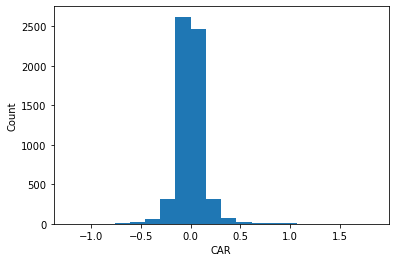

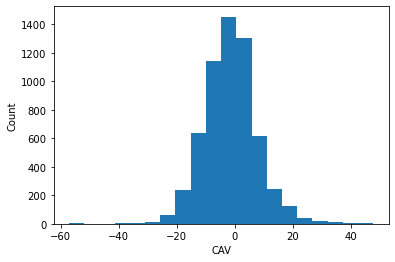

In [298]:
# generate plots of CAR and CAV
plt.figure()
plt.hist(cik_date_filter['CAR'], bins=20)
plt.xlabel('CAR')
plt.ylabel('Count')
plt.show()

plt.figure()
plt.hist(cik_date_filter['CAV'], bins=20)
plt.xlabel('CAV')
plt.ylabel('Count')
plt.show()

As we can see our cumulative abnormal returns and volume are both slightly right skewed, with greater mean than median. The median cumulative abnormal return is barely negative, with the mean being slightly more positive. The t-test for our cumulative abnormal returns has t-stat about 2.03 with p-value 0.043, so we reject the null hypothesis that the returns are equal to zero in favor of the alternative hypothesis that the returns are different from zero. We find a similar results from the t-test for the cumulative abnormal returns. 

## Assignment 12.2 Step 1

### Word Sentiment Quintile Descriptive Stats

In [62]:
word_sent_quintiles

word_sent_quintile          1          2          3          4          5
CAV mean            -0.556905  -1.867508  -1.668364  -1.636116  -1.675927
    std              9.907772   9.394732   9.248718   9.085346   8.706824
    min            -53.758133 -53.174781 -31.730678 -38.764821 -57.185311
    q25             -6.683486  -7.968543  -7.636479  -7.470159  -6.877466
    median          -0.810469  -1.934179  -2.183648  -1.644664  -1.371084
    q75              4.664403   3.332842   3.973583   3.587396   3.495055
    max             47.759839  36.910909  41.609927  38.623942  45.862032
CAR mean             0.000296  -0.005551   0.004869   0.003655   0.014737
    std              0.154011   0.141877   0.132268   0.121695   0.130172
    min             -1.048559  -1.225169  -0.668503  -0.598852  -0.693743
    q25             -0.054874  -0.054529  -0.048433  -0.041389  -0.042596
    median          -0.004371  -0.005576  -0.001646   0.001871   0.002346
    q75              0.049862   0.041851   0.047310   0.042850   0.057303
    max              1.021519   1.143243   1.838407   1.518048   1.296687

Looking at our quintile grouped cumulative abnormal returns, we see trends as expected. For the mean, median, q25, and q75, returns are mostly increasing with the higher quintiles. The trends are harder to distinguish in the cumulative abnormal volume calculations.

## Assignment 12.2 Step 2

### Sentence Tone Quintile Descriptive Stats With NLTK Sentence Tokenization and VADER Sentiment Analysis

In [171]:
sent_tone_quintiles

word_sent_quintile          1          2          3          4          5
CAV mean            -0.342023  -1.842611  -1.419678  -1.109448  -1.361537
    std              9.803970   9.299488   9.649118   9.108276   8.693942
    min            -52.789832 -53.174781 -31.730678 -38.764821 -57.185311
    q25             -6.207660  -7.779061  -7.703552  -6.976880  -6.322818
    median          -0.587728  -1.693422  -2.353228  -1.252866  -1.045550
    q75              4.690775   3.346166   4.290010   4.174640   3.692893
    max             47.759839  35.815093  41.609927  38.623942  45.862032
CAR mean             0.001521  -0.003231   0.006872   0.002289   0.014067
    std              0.150544   0.139951   0.138634   0.117512   0.134328
    min             -1.048559  -1.225169  -0.668503  -0.598852  -0.693743
    q25             -0.055597  -0.054618  -0.046263  -0.043402  -0.044548
    median          -0.003930  -0.003410   0.000588   0.001751   0.002422
    q75              0.050564   0.045380   0.051974   0.046328   0.059163
    max              1.021519   0.878391   1.838407   0.932959   1.296687

We see similar trends in the cumulative average returns across increasing quintiles. Higher quintiles tend to have higher cumulative average returns. For cumulative average volume, the results are similar. A small negative mean that jumps down in quintile 2 and then drops back down for the later quintiles.